<a href="https://colab.research.google.com/github/OlehKSS/cad-project/blob/master/Mole_classification_final_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mole Classification

In [0]:
import io
import os


import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

!pip install telepyth
import telepyth
%telepyth -t 7857737071561367176
# Use %telepyth 'Very magic, wow!'

  Running setup.py bdist_wheel for telepyth ... - done
  Stored in directory: /root/.cache/pip/wheels/c6/ba/88/e4b7afdac117701c7e90b688f57766f9dd792317465b8007ba
Successfully built telepyth


Use token 7857737071561367176.


In [0]:
tf.test.is_gpu_available()

True

In [0]:
tf.__version__

'1.12.0'

## Google Drive

In [0]:
# login to drive
from google.colab import auth
from googleapiclient.http import MediaFileUpload, MediaIoBaseDownload
from googleapiclient.discovery import build


auth.authenticate_user()

drive_service = build('drive', 'v3')

In [0]:
# helper functions
def get_file(file_id, file_name):
  '''Get a file from GoogleDrive.'''
  request = drive_service.files().get_media(fileId=file_id)
  #downloaded = io.BytesIO()
  downloaded = io.FileIO(file_name, 'wb')
  downloader = MediaIoBaseDownload(downloaded, request)
  done = False
  
  while done is False:
    # _ is a placeholder for a progress object that we ignore.
    # (Our file is small, so we skip reporting progress.)
    status, done = downloader.next_chunk()
     
    perc = int(100 * status.progress())
    print('\r[%s%s]' % ('=' * perc, ' ' * (50 - perc)))
  
  #downloaded.seek(0)
  #print(os.fstat(downloaded.fileno()).st_size)
  downloaded.flush()
  os.fsync(downloaded)
  downloaded.close()
  print('File has been downloaded successfully!')
  
  #return downloaded
  
  
def save_file_to_drive(name, path):
  """Save a file to GoogleDrive."""
  file_metadata = {'name': name, 'mimeType': 'application/octet-stream'}

  media = MediaFileUpload(path, mimetype='application/octet-stream', resumable=True)

  created = drive_service.files().create(body=file_metadata, media_body=media, fields='id').execute()

  return created


def unzip_tar(file_path, out_path):
  """
  Unzip tar.gz files.
  
  Args:
    file_path (str): path to the file to unzip.
    out_path (str): output path.
  """
  import tarfile
  
  tar = tarfile.open(file_path, "r:gz")
  tar.extractall(out_path)
  tar.close()
  

def val_test_split(val_path, test_path, split=0.5):
  """
  Split our validation data into validation/test sets.
  
  Args:
    val_path (str): validation data path.
    test_path (str): path where test files will be copied.
    spit (float): split ratio, e.g. if split=0.3, it means that 30% of images 
      from validation set  will be moved to test set.
  """
  from shutil import move
  from os import listdir
  from os.path import isdir, join
  from random import sample
  
  onlydirs = tuple(f for f in listdir(val_path) if isdir(join(val_path, f)))
  
  os.mkdir(test_path)
  
  for dir in onlydirs:
    os.mkdir(join(test_path, dir))
    files = tuple(f for f in listdir(join(val_path, dir)) if not isdir(join(val_path, dir, f)))
    # number of files to choose
    k = int(split * len(files))
    
    files_to_move = sample(files, k)
    
    for file in files_to_move:
      move(join(val_path, dir, file), join(test_path, dir))
  

def copy_folder_contents(src, dst, replace=False):
  """Copy contents of one folder with subfolders into another.
  
  Args:
    src (str): path to the source folder.
    dst (str): path to the destination folder.
    replace (bool): replace files with same names.
  """
  import os
  import shutil
  
  sub_folders = tuple(d for d in os.listdir(src) if os.path.isdir(os.path.join(src, d)))
  
  if len(sub_folders) != 0:
    for d in sub_folders:
      src_files = os.listdir(os.path.join(src, d))

      for file_name in src_files:
        full_file_name = os.path.join(src, d, file_name)

        if (os.path.isfile(full_file_name)):
          if not replace:
            shutil.copyfile(full_file_name, os.path.join(dst, d, d + file_name))
          else:
            shutil.copy(full_file_name, os.path.join(dst, d))

  else:
    for file_name in src_files:
      full_file_name = os.path.join(src, file_name)

      if (os.path.isfile(full_file_name)):
          if not replace:
            shutil.copyfile(full_file_name, os.path.join(dst, d, d + file_name))
          else:
            shutil.copy(full_file_name, dst)
          
          
def plot_history(history):
    """Plot training history of the Keras model."""
    hist = history.history

    acc = hist['acc']
    val_acc = hist['val_acc']
    loss = hist['loss']
    val_loss = hist['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, '*-', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, '*-', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

# Challenge 1

## Get Data

In [0]:
# CAD challenge 1, simple classification
train_data_id = '1AntSN4wcQ5x48wYXKnXJRzksPZYagQIr'
val_data_id = '14WHiW3wfjKKSbqXExzuWzxWwj-mVlA-F'

data_dir = './challenge1'

os.mkdir(data_dir)

train_file_name = os.path.join(data_dir, 'train.tar.gz')
val_data_name = os.path.join(data_dir, 'val.tar.gz')

get_file(train_data_id, train_file_name)
get_file(val_data_id, val_data_name)

%telepyth 'Data downloaded!'

[=======                                           ]
[===============                                   ]
[=======================                           ]
[===============================                   ]
[=======================================           ]
[===============================================   ]
[=======================================================]
[==============================================================]
[======================================================================]
[==============================================================================]
[======================================================================================]
[==============================================================================================]
[====================================================================================================]
File has been downloaded successfully!
[===============================                   ]
[=======================

'Data downloaded!'

In [0]:
#! rm -rf data
# !unzip ./data.zip

train_path = os.path.join(data_dir, 'train')
val_path = os.path.join(data_dir, 'val')
test_path = os.path.join(data_dir, 'test')

# since archive contains a folder already
unzip_tar(train_file_name, data_dir)
unzip_tar(val_data_name, data_dir)


val_test_split(val_path, test_path)

#val_test_split(val_path, test_path)
%telepyth 'Data split into train and val'

'Data split into train and val'

## Prepa Data Generator

In [0]:
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16, Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

from sklearn.metrics import classification_report, confusion_matrix

In [0]:
input_img_shape = (400, 300, 3)
no_epochs_train = 40
no_epochs_fine_tuning = 200
steps_per_epoch = 100
validation_steps = 50

In [0]:
# with data augentation
train_datagen = ImageDataGenerator(rescale=1./255, samplewise_center=True, rotation_range=40,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                  zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255, samplewise_center=True)

train_gen = train_datagen.flow_from_directory(train_path, target_size=input_img_shape[:2],
                                              batch_size=20, class_mode='binary')
validation_gen = test_datagen.flow_from_directory(val_path, target_size=input_img_shape[:2],
                                              batch_size=20, class_mode='binary')

test_gen = test_datagen.flow_from_directory(test_path,
                                            target_size=input_img_shape[:2],
                                            batch_size=20,
                                            #class_mode=None,
                                            shuffle=False)

train_gen.class_indices

Found 6000 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.


{'les': 0, 'nv': 1}

## Baseline for VGG16

In [0]:
conv_base_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_img_shape)

conv_base_vgg16.summary()
%telepyth 'VGG16 downloaded'

58892288/58889256 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 150, 128)     147584    
_________________________________________________________________
block2_pool

'VGG16 downloaded'

In [0]:
# densely connected classifier on top of the convolutional base
model_vgg16 = models.Sequential()
model_vgg16.add(conv_base_vgg16)
model_vgg16.add(layers.Flatten())

model_vgg16.add(layers.BatchNormalization())
model_vgg16.add(layers.Dense(512, activation='relu'))
model_vgg16.add(layers.Dropout(0.2))

model_vgg16.add(layers.BatchNormalization())
model_vgg16.add(layers.Dense(512, activation='relu'))
model_vgg16.add(layers.Dropout(0.2))

model_vgg16.add(layers.BatchNormalization())
model_vgg16.add(layers.Dense(1, activation='sigmoid'))

# freeze convolutional base
conv_base_vgg16.trainable = False

model_vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 12, 9, 512)        14714688  
_________________________________________________________________
flatten (Flatten)            (None, 55296)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 55296)             221184    
_________________________________________________________________
dense (Dense)                (None, 512)               28312064  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
__________

In [0]:
%telepyth 'Training begun!'

model_vgg16.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

history_vgg16 = model_vgg16.fit_generator(train_gen, steps_per_epoch=steps_per_epoch, epochs=no_epochs_train, validation_data=validation_gen,
                              validation_steps=validation_steps)
%telepyth 'Training finished!'

'Training begun!'

Epoch 1/40
100/100 [==============================] - 121s 1s/step - loss: 0.5931 - acc: 0.7230 - val_loss: 0.5694 - val_acc: 0.7680
Epoch 2/40
100/100 [==============================] - 114s 1s/step - loss: 0.5892 - acc: 0.7385 - val_loss: 0.5240 - val_acc: 0.7770
Epoch 3/40
100/100 [==============================] - 114s 1s/step - loss: 0.5863 - acc: 0.7285 - val_loss: 0.4771 - val_acc: 0.8070
Epoch 4/40
100/100 [==============================] - 113s 1s/step - loss: 0.5208 - acc: 0.7600 - val_loss: 0.4548 - val_acc: 0.8030
Epoch 5/40
100/100 [==============================] - 114s 1s/step - loss: 0.5514 - acc: 0.7475 - val_loss: 0.4359 - val_acc: 0.8010
Epoch 6/40
100/100 [==============================] - 114s 1s/step - loss: 0.5163 - acc: 0.7690 - val_loss: 0.4426 - val_acc: 0.8170
Epoch 7/40
100/100 [==============================] - 112s 1s/step - loss: 0.5427 - acc: 0.7590 - val_loss: 0.4352 - val_acc: 0.8110
Epoch 8/40
100/100 [==============================] - 113s 1s/step - 

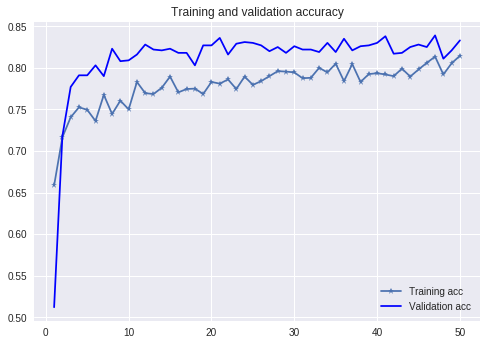

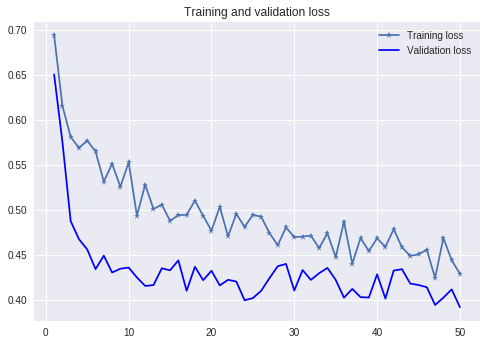

Confusion Matrix
[[254  46]
 [ 55 245]]
Classification Report
              precision    recall  f1-score   support

         les       0.82      0.85      0.83       300
          nv       0.84      0.82      0.83       300

   micro avg       0.83      0.83      0.83       600
   macro avg       0.83      0.83      0.83       600
weighted avg       0.83      0.83      0.83       600



'Trained network tested!'

In [0]:
# test the trained network
plot_history(history_vgg16)

Y_pred = model_vgg16.predict_classes(test_gen)
y_pred = [p[0] for p in Y_pred]

print('Confusion Matrix')
print(confusion_matrix(test_gen.classes, y_pred))

print('Classification Report')
target_names = ['les', 'nv']
print(classification_report(test_gen.classes, y_pred, target_names=target_names))
%telepyth 'Trained network tested!'

## Fine-tuning

In [0]:
# fine-tuning
# block5_conv1, block5_conv2, and block5_conv3 will be trained as well
conv_base_vgg16.trainable = True

for layer in conv_base_vgg16.layers:
  if 'block5' in layer.name:
    layer.trainable = True
  else:
    layer.trainable = False
    

# decrease learning rate
def exp_decay(epoch, lr):
  from math import exp
  k = 0.1
  lrate = lr * exp(-k * epoch)
  
  print(epoch, lr)
  
  return lrate
    
# Set early stopping condition if no increase in accuracy for 10 epochs    
callbacks_list = [
  keras.callbacks.EarlyStopping(monitor='acc', patience=10),
  keras.callbacks.LearningRateScheduler(exp_decay)
]

no_epochs = 200
learning_rate=2e-5
decay_rate = learning_rate / no_epochs
model_vgg16.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=learning_rate), metrics=['acc'])

model_vgg16.summary()
%telepyth 'Fine tuning initialized!'

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 12288)             0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 12288)             49152     
_________________________________________________________________
dense_3 (Dense)              (None, 512)               6291968   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
__________

'Fine tuning initialized!'

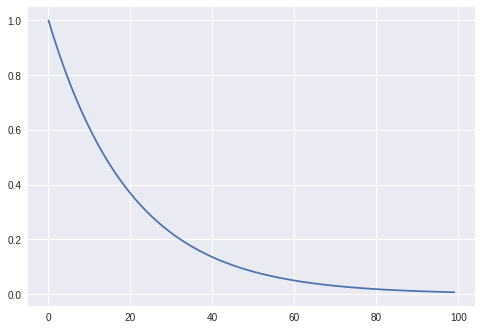

In [0]:
from math import exp

ilr = 2e-5
iepochs = tuple(range(0, 100))
rates = np.array(tuple(ilr * exp(- 0.1 * e) for e in iepochs)) / ilr

plt.plot(iepochs, rates)
plt.show()

In [0]:
%telepyth 'Fine tuning begun!'
history_vgg16 = model_vgg16.fit_generator(train_gen, steps_per_epoch=steps_per_epoch, epochs=no_epochs_fine_tuning, validation_data=validation_gen,
                              validation_steps=validation_steps,   callbacks=callbacks_list)
%telepyth 'Fine tuning finished!'

'Fine tuning begun!'

0 1.9999999494757503e-05
Epoch 1/200
100/100 [==============================] - 50s 503ms/step - loss: 0.4607 - acc: 0.7895 - val_loss: 0.4091 - val_acc: 0.8210
1 1.9999999494757503e-05
Epoch 2/200
100/100 [==============================] - 47s 472ms/step - loss: 0.4481 - acc: 0.8135 - val_loss: 0.4088 - val_acc: 0.8370
2 1.809674722608179e-05
Epoch 3/200
100/100 [==============================] - 48s 476ms/step - loss: 0.4538 - acc: 0.7965 - val_loss: 0.3939 - val_acc: 0.8290
3 1.4816363545833156e-05
Epoch 4/200
100/100 [==============================] - 47s 473ms/step - loss: 0.4487 - acc: 0.8075 - val_loss: 0.4103 - val_acc: 0.8230
4 1.0976232260873076e-05
Epoch 5/200
100/100 [==============================] - 48s 478ms/step - loss: 0.4584 - acc: 0.7935 - val_loss: 0.3903 - val_acc: 0.8360
5 7.357588401646353e-06
Epoch 6/200
100/100 [==============================] - 47s 466ms/step - loss: 0.4325 - acc: 0.8120 - val_loss: 0.3730 - val_acc: 0.8500
6 4.462603101273999e-06
Epoch 7/200


'Fine tuning finished!'

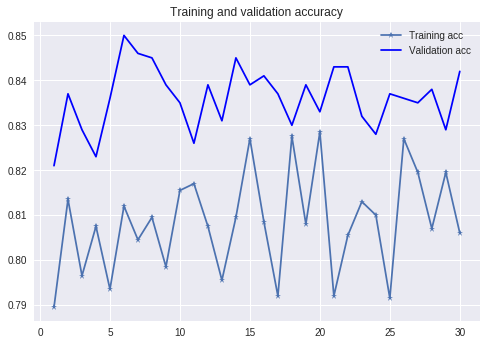

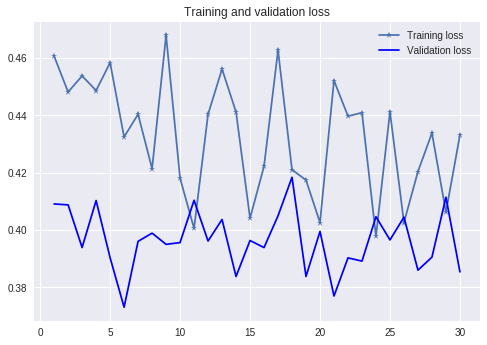

Confusion Matrix
[[250  50]
 [ 53 247]]
Classification Report
              precision    recall  f1-score   support

         les       0.83      0.83      0.83       300
          nv       0.83      0.82      0.83       300

   micro avg       0.83      0.83      0.83       600
   macro avg       0.83      0.83      0.83       600
weighted avg       0.83      0.83      0.83       600



'Fine training results plotted!'

In [0]:
# test the trained network
plot_history(history_vgg16)

# test_loss, test_acc = model_vgg16.evaluate_generator(test_gen, steps=50)
# print('test acc:', test_acc)
9

Y_pred = model_vgg16.predict_classes(test_gen)
y_pred = [p[0] for p in Y_pred]

print('Confusion Matrix')
print(confusion_matrix(test_gen.classes,ker y_pred))

print('Classification Report')
target_names = ['les', 'nv']
print(classification_report(test_gen.classes, y_pred, target_names=target_names))
%telepyth 'Fine training results plotted!'

# Challenge 2 

## Prepare Data

In [0]:
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16, Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

from sklearn.metrics import classification_report, confusion_matrix

In [0]:
# CAD challenge 1, simple classification
train_data_id = '1X8c_Xar0TSFdJmbDCcFSgFhUepn-M5wT'
val_data_id = '189Efrthti8rBw2aAIp7StSps4K9TrGUq'

data_dir = './challenge2'
os.mkdir(data_dir)

train_file_name = os.path.join(data_dir, 'train.tar.gz')
val_data_name = os.path.join(data_dir, 'val.tar.gz')

get_file(train_data_id, train_file_name)
get_file(val_data_id, val_data_name)

%telepyth 'Data downloaded!'

[==================                                ]
[=====================================             ]
[=======================================================]
[==========================================================================]
[=============================================================================================]
[====================================================================================================]
File has been downloaded successfully!
[===========================================================================]
[====================================================================================================]
File has been downloaded successfully!


'Data downloaded!'

In [0]:
#! rm -rf data
# !unzip ./data.zip

train_path = os.path.join(data_dir, 'train')
val_path = os.path.join(data_dir, 'val')
test_path = os.path.join(data_dir, 'test')

# since archive contains a folder already
unzip_tar(train_file_name, data_dir)
unzip_tar(val_data_name, data_dir)

val_test_split(val_path, test_path)

%telepyth 'Challenge 2 started. Data downloaded.'

'Challenge 2 started. Data downloaded.'

In [0]:
input_img_shape = (300, 225, 3) # bigger size gives an error
no_epochs_train = 40
no_epochs_fine_tuning = 200
steps_per_epoch = 100
validation_steps = 50

In [0]:
# with data augentation
train_datagen = ImageDataGenerator(rescale=1./255, samplewise_center=True, rotation_range=40,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                  zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255, samplewise_center=True)

train_gen = train_datagen.flow_from_directory(train_path, target_size=input_img_shape[:2],
                                              batch_size=20, class_mode='categorical')
validation_gen = test_datagen.flow_from_directory(val_path, target_size=input_img_shape[:2],
                                              batch_size=20, class_mode='categorical')

test_gen = test_datagen.flow_from_directory(test_path,
                                            target_size=input_img_shape[:2],
                                            batch_size=20,
                                            shuffle=False)

train_gen.class_indices

Found 2000 images belonging to 3 classes.
Found 250 images belonging to 3 classes.
Found 250 images belonging to 3 classes.


{'bcc': 0, 'bkl': 1, 'mel': 2}

## VGG16 Training

In [0]:
conv_base_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_img_shape)

%telepyth 'VGG16 downloaded'
conv_base_vgg16.summary()

In [0]:
# densely connected classifier on top of the convolutional base
model_vgg16 = models.Sequential()
model_vgg16.add(conv_base_vgg16)
model_vgg16.add(layers.Flatten())

model_vgg16.add(layers.BatchNormalization())
model_vgg16.add(layers.Dense(512, activation='relu'))
model_vgg16.add(layers.Dropout(0.2))

model_vgg16.add(layers.BatchNormalization())
model_vgg16.add(layers.Dense(512, activation='relu'))
model_vgg16.add(layers.Dropout(0.2))

model_vgg16.add(layers.BatchNormalization())
model_vgg16.add(layers.Dense(3, activation='softmax'))

# freeze convolutional base
conv_base_vgg16.trainable = False

model_vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 9, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 32256)             0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 32256)             129024    
_________________________________________________________________
dense_9 (Dense)              (None, 512)               16515584  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
__________

In [0]:
%telepyth 'Challege 2 training started.'
# we use here categorical_crossentropy instead of binary
model_vgg16.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

history_vgg16 = model_vgg16.fit_generator(train_gen, steps_per_epoch=steps_per_epoch, epochs=no_epochs_train, validation_data=validation_gen,
                              validation_steps=validation_steps)

%telepyth 'Training finished!'

'Challege 2 training started.'

Epoch 1/40
100/100 [==============================] - 75s 753ms/step - loss: 1.3739 - acc: 0.4570 - val_loss: 1.0628 - val_acc: 0.4289
Epoch 2/40
100/100 [==============================] - 69s 690ms/step - loss: 1.2118 - acc: 0.5020 - val_loss: 0.9389 - val_acc: 0.5897
Epoch 3/40
100/100 [==============================] - 69s 691ms/step - loss: 1.1354 - acc: 0.5430 - val_loss: 0.8501 - val_acc: 0.6206
Epoch 4/40
100/100 [==============================] - 70s 700ms/step - loss: 1.0565 - acc: 0.5670 - val_loss: 0.8505 - val_acc: 0.6227
Epoch 5/40
100/100 [==============================] - 69s 690ms/step - loss: 1.0353 - acc: 0.5845 - val_loss: 0.8910 - val_acc: 0.6216
Epoch 6/40
100/100 [==============================] - 69s 692ms/step - loss: 0.9945 - acc: 0.6140 - val_loss: 0.8504 - val_acc: 0.6258
Epoch 7/40
100/100 [==============================] - 69s 693ms/step - loss: 0.9574 - acc: 0.6245 - val_loss: 0.8627 - val_acc: 0.6464
Epoch 8/40
100/100 [==============================] - 7

'Training finished!'

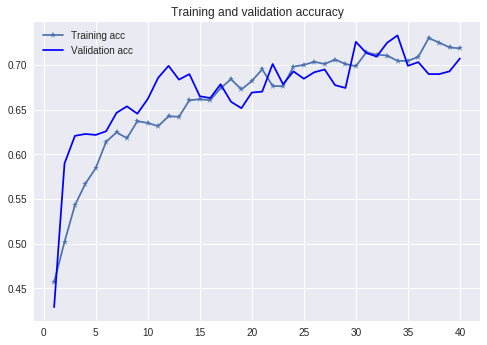

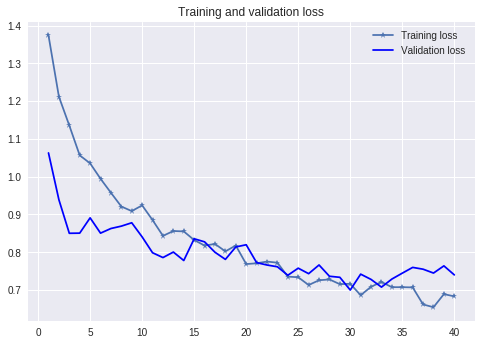

Confusion Matrix
[[35  7  8]
 [ 5 76 19]
 [ 3 18 79]]
Classification Report
              precision    recall  f1-score   support

         bcc       0.81      0.70      0.75        50
         bkl       0.75      0.76      0.76       100
         mel       0.75      0.79      0.77       100

   micro avg       0.76      0.76      0.76       250
   macro avg       0.77      0.75      0.76       250
weighted avg       0.76      0.76      0.76       250



In [0]:
# test the trained network
plot_history(history_vgg16)

# test_loss, test_acc = model_vgg16.evaluate_generator(test_gen, steps=50)
# print('test acc:', test_acc)


Y_pred = model_vgg16.predict_classes(test_gen)

print('Confusion Matrix')
print(confusion_matrix(test_gen.classes, Y_pred))

print('Classification Report')
target_names = ['bcc', 'bkl', 'mel']
print(classification_report(test_gen.classes, Y_pred, target_names=target_names))

## Fine-tuning

In [0]:
# block5_conv1, block5_conv2, and block5_conv3 will be trained as well
conv_base_vgg16.trainable = True

for layer in conv_base_vgg16.layers:
  if 'block5' in layer.name:
    layer.trainable = True
  else:
    layer.trainable = False
    

# decrease learning rate
def exp_decay(epoch, lr):
  from math import exp
  k = 0.1
  lrate = lr * exp(-k * epoch)
  
  print(epoch, lr)
  
  return lrate
    
# Set early stopping condition if no increase in accuracy for 10 epochs    
callbacks_list = [
  keras.callbacks.EarlyStopping(monitor='acc', patience=10),
  keras.callbacks.LearningRateScheduler(exp_decay)
]


learning_rate=2e-5
model_vgg16.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=learning_rate), metrics=['acc'])

model_vgg16.summary()
%telepyth 'Fine tuning initialized!'

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 9, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 32256)             0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 32256)             129024    
_________________________________________________________________
dense_9 (Dense)              (None, 512)               16515584  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
__________

'Fine tuning initialized!'

In [0]:
%telepyth 'Fine tuning begun!'
history_vgg16 = model_vgg16.fit_generator(train_gen, steps_per_epoch=steps_per_epoch, epochs=no_epochs_fine_tuning, validation_data=validation_gen,
                              validation_steps=validation_steps,   callbacks=callbacks_list)
%telepyth 'Fine tuning finished!'

'Fine tuning begun!'

0 1.9999999494757503e-05
Epoch 1/200
100/100 [==============================] - 78s 775ms/step - loss: 0.7162 - acc: 0.7005 - val_loss: 0.8409 - val_acc: 0.6763
1 1.9999999494757503e-05
Epoch 2/200
100/100 [==============================] - 75s 745ms/step - loss: 0.7054 - acc: 0.7120 - val_loss: 0.8925 - val_acc: 0.6330
2 1.809674722608179e-05
Epoch 3/200
100/100 [==============================] - 74s 744ms/step - loss: 0.6755 - acc: 0.7270 - val_loss: 0.8044 - val_acc: 0.6990
3 1.4816363545833156e-05
Epoch 4/200
100/100 [==============================] - 74s 740ms/step - loss: 0.6720 - acc: 0.7120 - val_loss: 0.8065 - val_acc: 0.6753
4 1.0976232260873076e-05
Epoch 5/200
100/100 [==============================] - 73s 733ms/step - loss: 0.6510 - acc: 0.7465 - val_loss: 0.8209 - val_acc: 0.6948
5 7.357588401646353e-06
Epoch 6/200
100/100 [==============================] - 74s 736ms/step - loss: 0.6124 - acc: 0.7495 - val_loss: 0.7470 - val_acc: 0.7186
6 4.462603101273999e-06
Epoch 7/200


'Fine tuning finished!'

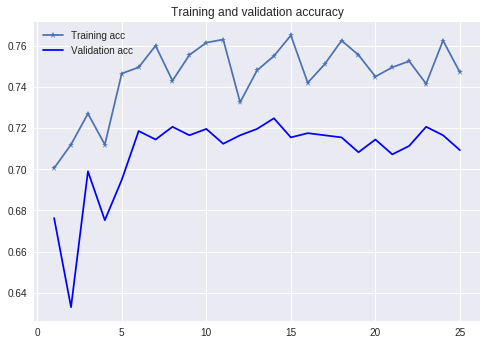

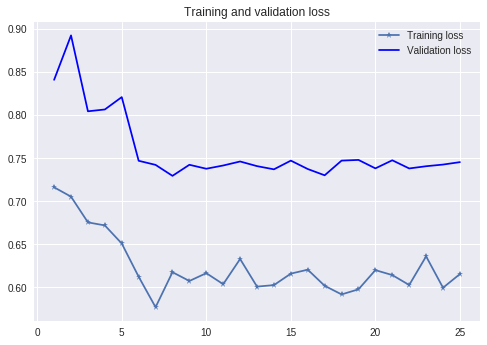

Confusion Matrix
[[29 11 10]
 [ 6 76 18]
 [ 3 17 80]]
Classification Report
              precision    recall  f1-score   support

         bcc       0.76      0.58      0.66        50
         bkl       0.73      0.76      0.75       100
         mel       0.74      0.80      0.77       100

   micro avg       0.74      0.74      0.74       250
   macro avg       0.74      0.71      0.72       250
weighted avg       0.74      0.74      0.74       250



In [0]:
# test the trained network
plot_history(history_vgg16)

# test_loss, test_acc = model_vgg16.evaluate_generator(test_gen, steps=50)
# print('test acc:', test_acc)


Y_pred = model_vgg16.predict_classes(test_gen)

print('Confusion Matrix')
print(confusion_matrix(test_gen.classes, Y_pred))

print('Classification Report')
target_names = ['bcc', 'bkl', 'mel']
print(classification_report(test_gen.classes, Y_pred, target_names=target_names))